In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('prepr_abstract_field_GM_all_1.csv')

In [3]:
df.head()

,id,field,prepr_abstract,lang
0,0,Humanities,scholars have identified two supposedly separa...,en
1,1,Humanities,a discussion of the second part of lucretius' ...,en
2,2,Humanities,according to many ancient historians the secon...,en
3,3,Humanities,the old persian line in aristophanes' acharnia...,en
4,4,Humanities,this essay presents a sketch of a sociological...,en


In [6]:
np.unique(df.field)

array(['Art', 'Biology', 'Business', 'Chemistry', 'Geology', 'Humanities',
       'Math', 'Medicine', 'Physics', 'Psychology', 'Social', 'Tech'],
      dtype=object)

In [4]:
df = df[df.field != '???']

In [5]:
def field2hyperfield(field):
    f2h = {'Art': 'Art and Humanities',
           'Biology': 'Biology and Medicine',
           'Business': 'Business',
           'Chemistry': 'Natural',
           'Geology': 'Natural',
           'Humanities': 'Art and Humanities',
           'Math': 'Formal',
           'Medicine': 'Biology and Medicine',
           'Physics': 'Natural',
           'Psychology': 'Biology and Medicine',
           'Social': 'Art and Humanities',
           'Tech': 'Formal'}
    return f2h[field]

In [5]:
df['hyperfield'] = df['field'].apply(field2hyperfield)

In [6]:
for field in np.unique(df.field):
    print(field, df[df.field == field].shape[0])

Biology 445100
Business 33501
Chemistry 188663
Geology 48141
Humanities 142009
Math 71148
Medicine 625736
Physics 412923
Psychology 40564
Social 52528
Tech 32762


In [5]:
def func(x):
    if x == 'Art':
        return 'Humanities'
    else:
        return x

df['field'] = df['field'].apply(func)

In [68]:
df_balanced = pd.concat(
    [
        df[df.field == 'Biology'].sample(np.random.randint(500, 700)),
        #df[df.field == 'Chemistry'].sample(np.random.randint(500, 700)),
        #df[df.field == 'Humanities'].sample(np.random.randint(500, 700)),
        #df[df.field == 'Medicine'].sample(np.random.randint(500, 700)),
        df[df.field == 'Physics'].sample(np.random.randint(500, 700)),
        #df[df.field == 'Math'].sample(np.random.randint(500, 700)),
        #df[df.field == 'Business'].sample(np.random.randint(100, 150)),
        df[df.field == 'Geology'].sample(np.random.randint(500, 700)),
        #df[df.field == 'Psychology'].sample(np.random.randint(100, 150)),
        #df[df.field == 'Social'].sample(np.random.randint(100, 150)),
        #df[df.field == 'Tech'].sample(np.random.randint(500, 700))
    ],
    ignore_index=True)

In [46]:
df.dropna(inplace=True)

In [22]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline

In [23]:
vectorizer = HashingVectorizer(ngram_range=(1, 2), stop_words='english')

In [71]:
X = df_balanced['prepr_abstract']

In [72]:
from sklearn.model_selection import train_test_split

labels = df_balanced['field']
X_train, X_test, y_train, y_test = train_test_split(X, labels, train_size=0.8, test_size=.2,
                                                    random_state=1337, stratify=labels)

In [73]:
import gc
gc.collect()

437

In [74]:
X_train.shape

(1480,)

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))

In [76]:
features = vectorizer.fit_transform(X_train, y_train)

In [77]:
from scipy.sparse import save_npz

save_npz('features_3cat_geo.npz', features)

In [78]:
np.save('labels_3cat_geo.npy', np.array(y_train))

In [67]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

features = lsa.fit_transform(features)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 0%


In [68]:
np.save('features_phys_med.npy', features)

In [52]:
from sklearn.cluster import MiniBatchKMeans

km = MiniBatchKMeans(n_clusters=np.unique(labels).shape[0], verbose=True, random_state=1337,
                     batch_size=10_000)

In [53]:
km.fit(features)

Init 1/3 with method: k-means++
Inertia for init 1/3: 18869.424591
Init 2/3 with method: k-means++
Inertia for init 2/3: 18863.581925
Init 3/3 with method: k-means++
Inertia for init 3/3: 18875.065619
Minibatch iteration 1/200: mean batch inertia: 0.981187, ewa inertia: 0.981187 
Minibatch iteration 2/200: mean batch inertia: 0.979964, ewa inertia: 0.979964 
Minibatch iteration 3/200: mean batch inertia: 0.979101, ewa inertia: 0.979101 
Minibatch iteration 4/200: mean batch inertia: 0.978835, ewa inertia: 0.978835 
Minibatch iteration 5/200: mean batch inertia: 0.978480, ewa inertia: 0.978480 
Minibatch iteration 6/200: mean batch inertia: 0.978003, ewa inertia: 0.978003 
Minibatch iteration 7/200: mean batch inertia: 0.977990, ewa inertia: 0.977990 
Minibatch iteration 8/200: mean batch inertia: 0.977888, ewa inertia: 0.977888 
Minibatch iteration 9/200: mean batch inertia: 0.977600, ewa inertia: 0.977600 
Minibatch iteration 10/200: mean batch inertia: 0.976911, ewa inertia: 0.976911

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=11,
        n_init=3, random_state=1337, reassignment_ratio=0.01, tol=0.0,
        verbose=True)

In [54]:
from sklearn import metrics

labels = y_train

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))

Homogeneity: 0.240
Completeness: 0.252
V-measure: 0.246
Adjusted Rand-Index: 0.147


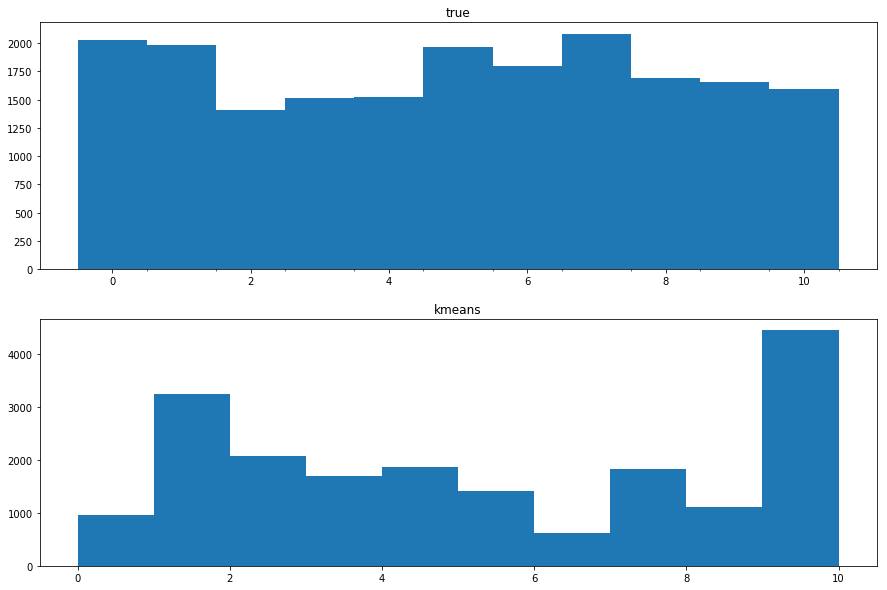

In [55]:
from collections import Counter

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))

l, values = zip(*Counter(labels).items())

indexes = np.arange(len(l))
width = 1

ax1.bar(indexes, values, width)
ax1.set_title('true')
ax1.set_xticks(indexes + width * 0.5, l)

ax2.hist(km.labels_)
ax2.set_title('kmeans')

plt.show()

In [56]:
for field in np.unique(df_balanced.field):
    print(field, df_balanced[df_balanced.field == field].shape[0])

Biology 2973
Business 2838
Chemistry 2571
Geology 2283
Humanities 2808
Math 2163
Medicine 2412
Physics 2178
Psychology 2008
Social 2363
Tech 2892
